In [160]:
import pandas as pd
from bs4 import BeautifulSoup

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re

# Read html file
def read_file(file_path: str) -> list:
    with open(file_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()
    list_words = text.replace('\n', ' ').split(' ')
    return list_words

# Preprocessing
def preprocess_text(ll: list) -> list:
    ll = [word for word in ll if word != '']
    ll = [word.lower() for word in ll]
    ll = [word.replace('\xa0', ' ') for word in ll]
    ll = [re.sub(r'[^\w\s]', '', word) for word in ll]
    ll = [re.sub(r'\d+', '', word) for word in ll]
    ll = [word for word in ll if word != '']
    ll = [w for w in ll if not w.isascii()]  # Remove english words (I hope)
    return ll

list_words = read_file('./final_dataset/1056.html')
list_words = preprocess_text(list_words)
script = ' '.join(list_words)

In [161]:
import os

files = os.listdir('./final_dataset')
files = [f for f in files if f.endswith('.html')]

df = pd.DataFrame(columns=['script'])
for f in files:
    list_words = read_file(f'./final_dataset/{f}')
    list_words = preprocess_text(list_words)
    script = ' '.join(list_words)
    df.loc[f] = script    

df.sort_index(inplace=True)

In [162]:
decisions = pd.read_csv('./final_dataset/annotated_dataset.csv')    
decisions.drop('Unnamed: 0', axis=1, inplace=True)  
decisions = decisions[decisions['Decision'].isin(df.index)]
decisions.set_index('Decision', inplace=True)
decisions.sort_index(inplace=True)

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer

with open('./stopwords.txt', 'r') as file:
    stop_words = file.read().split('\n')
    
stop_words = preprocess_text(stop_words)

tfidf = TfidfVectorizer(min_df=2, norm='l2', stop_words=stop_words)
tfidf_matrix = tfidf.fit_transform(df['script']).toarray()

data = pd.DataFrame(tfidf_matrix, index=df.index, columns=tfidf.get_feature_names_out())
data['target'] = decisions['Label'].values

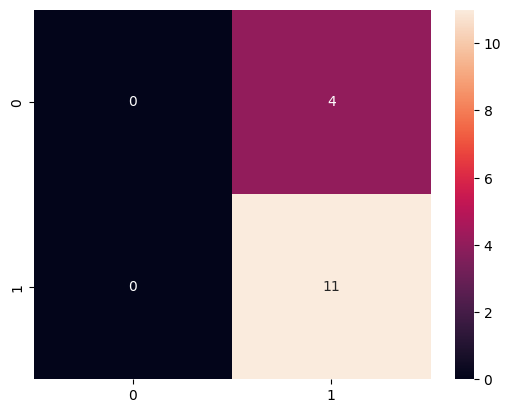

Accuracy: 0.7333333333333333
MCC: 0.846153846153846


In [199]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

rf = LogisticRegression(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

mcc = f1_score(y_test, y_pred)
print(f'MCC: {mcc}')

In [200]:
# Shap values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type='dot')
plt.show()

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>